In [79]:
import matplotlib.pyplot as plt
import numpy as np
import random

## Landscape Function

### Himmelblau's function
In mathematical optimization, Himmelblau's function is a multi-modal function 
used to test the performance of optimization algorithms.

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

- `Input domain`: this function is usually evaluated on the square $x,y \in [-4,4]$
- `Local maximum`
  - $f(-0.270845, -0.923039) = 181.617$
- `Global minima`
  - $f(3.0,2.0) = 0.0$
  - $f(-2.805118,3.131312) = 0.0$
  - $f(-3.779310,-3.283186) = 0.0$
  - $f(3.584428,-1.848126) = 0.0$

Since in computer science we usually want to maximize our objective function, I will use the negative of Himmelblau's function for its landscape representation.

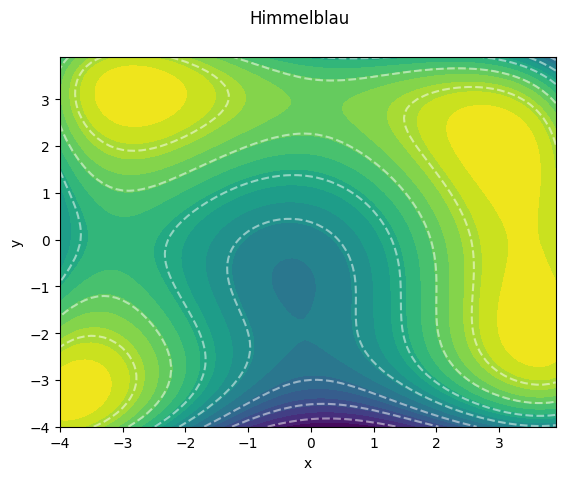

In [48]:

def visulize_himmelblau():
    x = np.arange(-4, 4, 0.1)
    y = np.arange(-4, 4, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

    fig = plt.figure('himmelblau')
    fig.suptitle('Himmelblau')
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap=plt.cm.viridis, levels=np.linspace(np.min(Z), 0, 20))
    ax.contour(X, Y, Z, colors='white', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

visulize_himmelblau()

In [141]:
def visualize_himmelblau(population=None):
    x = np.arange(-4.5, 4.5, 0.1)
    y = np.arange(-4.5, 4.5, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = -((X**2 + Y - 11)**2 + (X + Y**2 - 7)**2)

    fig = plt.figure('himmelblau')
    fig.suptitle('Himmelblau')
    ax = fig.gca()
    ax.contourf(X, Y, Z, cmap=plt.cm.viridis, levels=np.linspace(np.min(Z), 5, 30))
    ax.contour(X, Y, Z, colors='white', alpha=0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if population is not None:
        population_x = [ind[0] for ind in population]
        population_y = [ind[1] for ind in population]
        ax.scatter(population_x, population_y, color='red', marker='o', label='Population')

    plt.legend()
    plt.show()

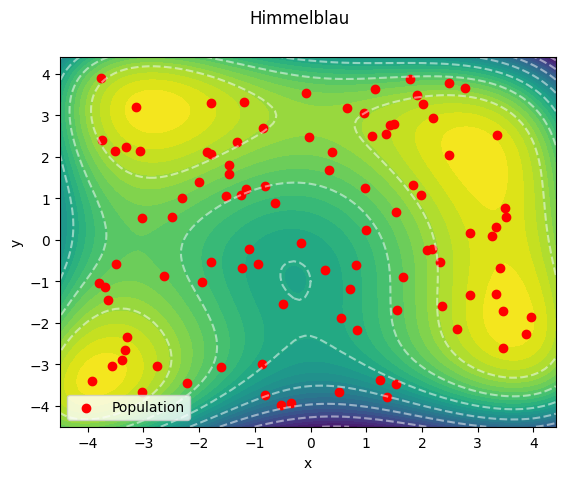

Best solution: (-3.7755696074224407, -3.281016514990539) Value: 0.0007909772036327879


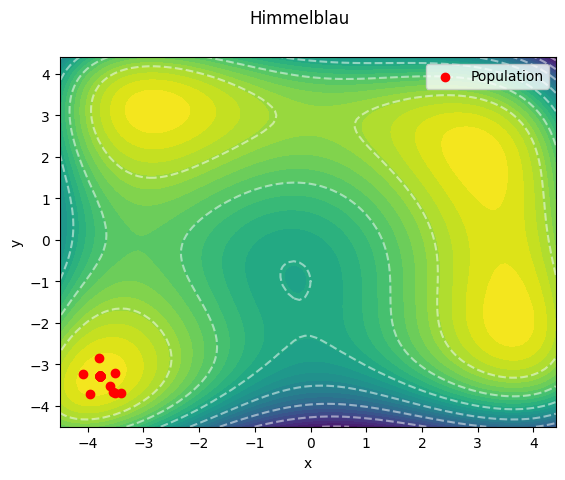

In [151]:

def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def initialize_population(population_size):
    return [(random.uniform(-4, 4), random.uniform(-4, 4)) for _ in range(population_size)]

def evaluate_population(population):
    return [himmelblau(x, y) for x, y in population]

def select_mating_pool(population, fitness_values, pool_size):
    return random.choices(population, weights=[1 / (f + 1e-6) for f in fitness_values], k=pool_size)

def crossover(parent1, parent2):
    x1, y1 = parent1
    x2, y2 = parent2
    return (x1, y2)

def mutate(individual, mutation_rate):
    x, y = individual
    if random.random() < mutation_rate:
        x += random.uniform(-0.5, 0.5)
        y += random.uniform(-0.5, 0.5)
    return (x, y)

population_size = 100
mutation_rate = 0.1
generations = 300

population = initialize_population(population_size)
visualize_himmelblau(population)
for generation in range(generations):
    fitness_values = evaluate_population(population)
    mating_pool = select_mating_pool(population, fitness_values, population_size // 2)
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = random.sample(mating_pool, 2)
        child1 = crossover(parent1, parent2)
        child2 = crossover(parent2, parent1)
        child1 = mutate(child1, mutation_rate)
        child2 = mutate(child2, mutation_rate)
        new_population.extend([child1, child2])
    population = new_population

best_solution = min(population, key=lambda ind: himmelblau(ind[0], ind[1]))
print("Best solution:", best_solution, "Value:", himmelblau(best_solution[0], best_solution[1]))
visualize_himmelblau(population)
